In [17]:
import numpy as np  # the Python array package
import matplotlib.pyplot as plt 
import nibabel as nib
import numpy.linalg as npl

%matplotlib inline

In [3]:
img = nib.load('data/ds114_sub009_t2r1.nii')
data = img.get_data()
data.shape

(64, 64, 30, 173)

We can think of the shape of the data as two parts - the first 3 values are the 3D shape of the individual volumes, and the last value is the number of volumes.

Put the 3D shape into a variable `vol_shape` and the number of volumes into a variable `n_vols`:

In [4]:
vol_shape = data.shape[:-1]
vol_shape 

(64, 64, 30)

In [5]:
n_vols = data.shape[-1]
n_vols

173

We are going to start by looking at only the first two "variables" (time points).

Slice the data array to make a new array that contains only the first two volumes:

In [7]:
# Slice the image data array to give array with only first two volumes
first_two = data[..., :2]
first_two.shape

(64, 64, 30, 2)

How many voxels are there in one volume?  Call this number variable `N`:

In [8]:
# Set N to be the number of voxels in a volume
N = np.prod(vol_shape)
N

122880

Reshape the new two-volume data array to have a first dimension length N and second dimension length 2. So, each column corresponds to the voxels for one volume.

In [9]:
# Reshape to 2D array with first dimension length N
first_two = first_two.reshape((N, 2))
first_two.shape

(122880, 2)

Take the transpose of this array to get a 2 by `N` array, ready for the PCA:

In [10]:
# Transpose to 2 by N array
first_two = first_two.T
first_two.shape

(2, 122880)

Calculate the mean across columns (row means):

In [11]:
# Calculate the mean across columns
row_means = np.mean(first_two, axis=1)
row_means

array([414.40107422, 336.69940592])

Expand the row_means vector out to a 2 by N array by using `np.outer` and a vector of ones:

In [12]:
# Row means copied N times to become a 2 by N array
row_means = np.outer(row_means, np.ones(N))
row_means.shape

(2, 122880)

Subtract this expanded 2 by N means array from the 2 by N data matrix and put the result into a variable X. Print the means across columns (row means) to check they are now very close to 0:

In [13]:
# Subtract the means for each row, put the result into X
# Show the means over the columns, after the subtraction
X = first_two - row_means
np.mean(X, axis=1)

array([-1.51582450e-14,  1.36424205e-13])

Plot the two rows against each other to get a feel for the variation.  Remember that each row in `X` is a volume, so you are plotting the signal from the first volume against the signal for the second volume.

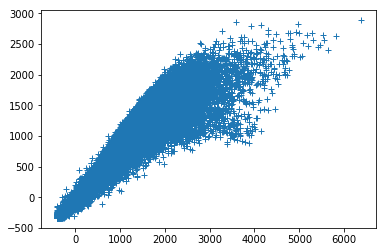

In [14]:
# Plot the signal in the first row against the signal in the second
plt.plot(X[0], X[1], '+')

#### Time for the PCA.

We are going to use the *unscaled* covariance.  This is given by the matrix multiplication of `X` with its transpose.  Calculate this:

In [15]:
# Calculate unscaled covariance matrix for X
unscaled_covariance = X.dot(X.T)
unscaled_covariance

array([[8.04237807e+10, 6.12641298e+10],
       [6.12641298e+10, 4.92491046e+10]])

Use SVD to get the U, S and V matrices from the unscaled covariance:

In [18]:
# Use SVD to return U, S, V matrices from unscaled covariance
U, S, V = npl.svd(unscaled_covariance)

Confirm that the row vectors in `V` are both unit vectors.  A unit vector has vector length (vector *norm* of 1):

In [19]:
# Show that the rows in V each have vector length 1
np.sum(V ** 2, axis=1)

array([1., 1.])

Confirm that the first row in `V` is orthogonal to the second:

In [20]:
# Confirm orthogonality of rows in V
V[0].dot(V[1])

0.0

Show the total sum of squares in `X`.   Confirm that the total sum of squares in `X` is the same as the sum of the *singular values* in the `S` vector from the SVD:

In [21]:
# Show the total sum of squares in X
# Is this (nearly) the same as the sum of the values in S?
print(np.sum(X ** 2))
print(np.sum(S))

129672885307.41481
129672885307.41481


Plot the first row in `X` against the second row in `X` again.  This time add a line corresponding to the first principal component.  You'll have to scale this line (a unit vector) to make it long enough to see on the axes of the plot.  If the first principal component is flipped ($\vec{r}$ defines same line as $-\vec{r}$) you may need to scale by a negative number for it to look nice on the plot:

3157.9395737007

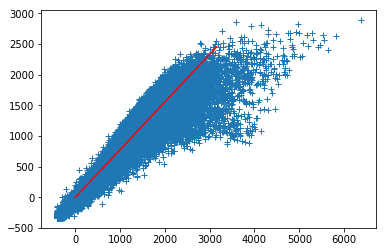

In [22]:
# Plot the signal in the first row against the signal in the second
# Plot line corresponding to a scaled version of the first principal component
# (Scaling may need to be negative)
plt.plot(X[0], X[1], '+')
scaled_v = V[0] * -4000
plt.plot([0, scaled_v[0]], [0, scaled_v[1]], 'r')
scaled_v[0]

Remember the projection formula $c = \hat{u} \cdot \vec{v}$.   

We now need to calculate the projection coefficients $c$ for each component $\hat{u}$ and each voxel (each $\vec{v}$).

This will give us a new output matrix of coefficients $C$ which is shape `(2, N)`, where the rows give the coefficients for one component, and the columns give the coefficients for one voxel.

For example, `C[0, 0]` will be the result of `V[0].dot(X[:, 0])`, `C[0, 1]` will be the result of `V[0].dot(X[:, 1])`, and `C[1, 0]` will be the result of `V[1].dot(X[:, 0])`.

With that background, see if you can use matrix multiplication to calculate the projection coefficients `C` for projecting the data `X` onto the vectors in `V`:

In [23]:
# Calculate the projection coefficients for projecting X onto the vectors in V
# Put the result into a new array C.
C = V.dot(first_two)
C.shape

(2, 122880)

Remember that `C` - the projection coefficients - has one column per voxel.  We can think of each row as corresponding to a volume where the volumes are contained in: `C[0]` (first row of `C`) - projection coefficients for first principal component; `C[1]` (second row of C) - projection coefficients for second principal component.
    
    
Take the transpose of `C` and reshape the resulting first dimension (length `N`) back to `vol_shape` - the original shape of the 3D volumes in the data.

In [24]:
# Transpose C
# Reshape the first dimension of C to have the 3D shape of the original data volumes.
C_vols = C.T.reshape(vol_shape + (2,))
C_vols.shape

(64, 64, 30, 2)

Break this 4D array up into two volumes (volume for first component, volume for second component) using slicing:

In [25]:
# Break 4D array into two 3D volumes
vol0 = C_vols[..., 0]
vol1 = C_vols[..., 1]

In [28]:
vol0.shape, vol0.size

((64, 64, 30), 122880)

In [29]:
vol1.shape, vol1.size

((64, 64, 30), 122880)

Show the middle slice (slice over the third dimension) from the volume of coefficients for the first component:

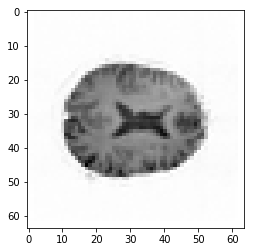

In [30]:
# Show middle slice (over third dimension) from volume of coefficients for first component
plt.imshow(vol0[:, :, 14], cmap='gray')

Show the middle slice (slice over the third dimension) from the volume of coefficients for the second component:

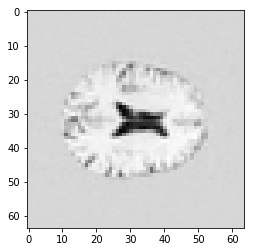

In [31]:
# Show middle slice (over third dimension) from volume of coefficients for second component
plt.imshow(vol1[:, :, 14], cmap='gray')

Now we are ready to do the same thing for all the time points, instead of just the first two.

Take the original array data matrix with `n_vols` volumes.  Reshape to be shape `(N, nvols)`.  Take the transpose to get an array shape `(n_vols, N)`:

In [32]:
# Reshape first dimension of whole image data array to N, and take transpose
arr = data.reshape(N, n_vols).T
arr.shape

(173, 122880)

Calculate the mean across columns (mean per volume).  Expand this 1D shape `(173,)` vector to an array shape `(173, N)`, using `np.outer` and a vector of ones.  Subtract this array from the `(173, N)` data array to remove the mean across columns (mean per volume).  Call this mean-corrected variable `X`:

In [33]:
# Calculate mean across columns
# Expand to (173, N) shape using np.outer
# Subtract from data array to remove mean over columns (row means)
# Put result into array X
row_means = np.outer(np.mean(arr, axis=1), np.ones(N))
X = arr - row_means

Get the unscaled covariance matrix of X:

In [34]:
# Calculate unscaled covariance matrix of X
unscaled_covariance = X.dot(X.T)
unscaled_covariance.shape

(173, 173)

Get U, S, V outputs from the SVD of the unscaled covariance

In [35]:
# Calculate U, S, V with SVD on unscaled covariance matrix
U, S, V = npl.svd(unscaled_covariance)

Use `plt.subplots` to make a column of 10 axes.  Iterate over these axes, plotting one principal component vector per axis.  You should then have a plot of each of the first 10 principal component vectors:

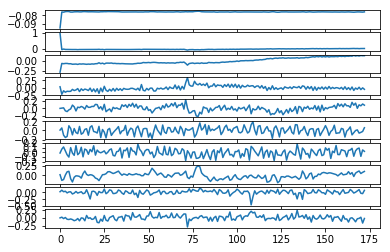

In [36]:
# Use subplots to make axes to plot first 10 principle component vectors
# Plot one component vector per sub-plot.
fig, axes = plt.subplots(10, 1)
for i, ax in enumerate(axes):
    ax.plot(V[i])

Use `V` and matrix multiplication to calculate the projection coefficients for projecting the data `X` onto the principal components `V`.  Put the result into `C`:

In [37]:
# Calculate projection coefficients for projecting X onto V
# Put results into array C.
C = V.dot(X)

Remember, each row of `C` is a full volume of projection coefficients, one row per principal component.

Reconstruct these rows as volumes by taking the transpose of `C` and reshaping the first dimension length `N` to the original three dimensions of the original data volumes.

In [38]:
# Transpose C
# Reshape the first dimension of C to have the 3D shape of the original data volumes.
C_vols = C.T.reshape(img.shape)

Take the first volume (corresponding to the first principal component) and display the middle slice (slicing over the third dimension):

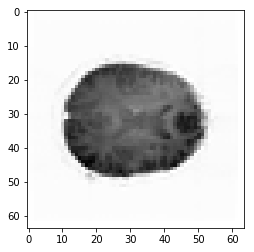

In [39]:
# Show middle slice (over third dimension) of first principal component volume
plt.imshow(C_vols[:, :, 14, 0], cmap='gray')

#### What does this first component show us?

Remember that the projections coefficients tell us how much of the component vector there is in the data, at each voxel.  If the voxel has a high value it means there is a large amplitude of the component time-course at this voxel, and if the component is dark it means there is a large negative amplitude of the component time course.

Have a look again at the first component time course.  How would a large positive or negative amplitude of the time course come about?

As a hint while you are thinking, get the mean over time from the image data (mean over the last axis), and show the middle slice (slicing over the third axis):

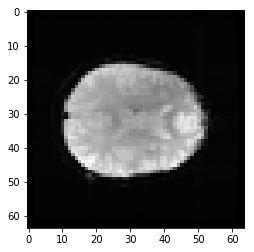

In [40]:
# Make the mean volume (mean over the last axis)
# Show the middle slice (slicing over the third axis)
mean_vol = data.mean(axis=-1)
plt.imshow(mean_vol[:, :, 14], cmap='gray')

Display the middle slice (slicing over the third dimension) for the second principal component volume.

Looking at the principal component plot - what kind of changes over time does this principal component represent?


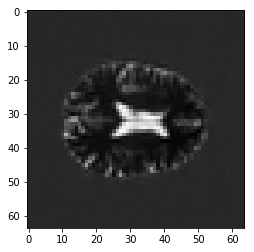

In [41]:
# Show middle slice (over third dimension) of second principal component volume
plt.imshow(C_vols[:, :, 14, 1], cmap='gray')

Do the same for the third principal component volume:

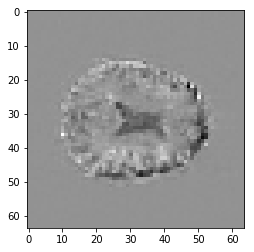

In [42]:
# Show middle slice (over third dimension) of third principal component volume
plt.imshow(C_vols[:, :, 14, 2], cmap='gray')